In [11]:

from copy import copy
import numpy as np
import matplotlib.pyplot as plt

# particula imports
from particula.next import particles
from particula.next.aerosol import Aerosol

from particula.next.gas.species_builders import PresetGasSpeciesBuilder
from particula.next.gas.atmosphere_builders import AtmosphereBuilder

from particula.next.dynamics import particle_process
from particula.next.dynamics import coagulation

In [12]:
# Preset gas species that does not condense
atmosphere = (
    AtmosphereBuilder()
    .add_species(PresetGasSpeciesBuilder().build())
    .set_temperature(25, temperature_units="degC")
    .set_pressure(1, pressure_units="atm")
    .build()
)

# Particle distribution
particle_sample = particles.properties.lognormal_sample_distribution(
    mode= np.array([100e-9]),
    geometric_standard_deviation= np.array([1.3]),
    number_of_particles= np.array([1e4]),
    number_of_samples=100_000,
)

particle_mass_sample = 4 / 3 * np.pi * particle_sample ** 3 * 1500 # kg

resolved_masses = (
    particles.ResolvedParticleMassRepresentationBuilder()
    .set_distribution_strategy(particles.ParticleResolvedSpeciatedMass())
    .set_activity_strategy(particles.ActivityIdealMass())
    .set_surface_strategy(particles.SurfaceStrategyVolume())
    .set_mass(particle_mass_sample, "kg")
    .set_density(1500, "kg/m^3")
    .set_charge(0)
    .set_volume(0.1, "cm^3")
    .set_mass(particle_mass_sample, "kg")
    .build()
)

aerosol = Aerosol(atmosphere=atmosphere, particles=resolved_masses)

print(aerosol.atmosphere)


Gas mixture at 298.15 K and 101325.0 Pa consisting of ['Preset100']


Particles that coagulated: 36554


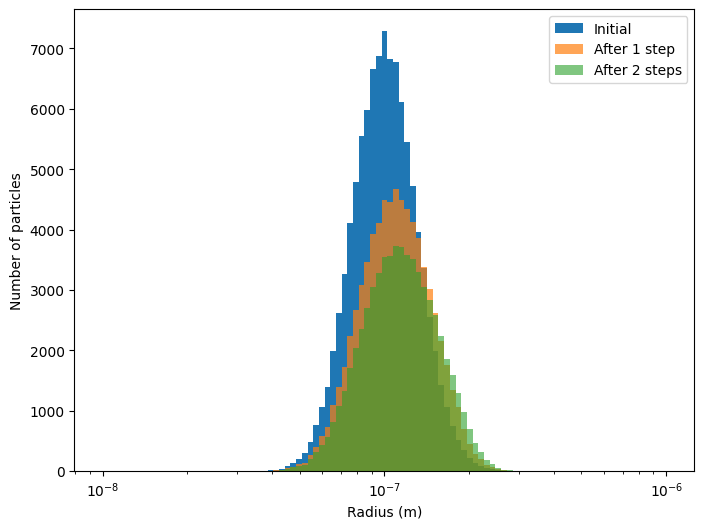

In [13]:
coagulation_strategy = coagulation.ParticleResolved()
coagulation_process = particle_process.Coagulation(coagulation_strategy=coagulation_strategy)

# Coagulation
time_step = 1000
sub_steps = 100

bins_lognormal = np.logspace(-8, -6, 100)


fig, ax = plt.subplots(figsize=(8, 6))
bins, edges = np.histogram(
    aerosol.particles[0].get_radius(), bins=bins_lognormal
)
ax.bar(edges[:-1], bins, width=np.diff(edges), align="edge", label="Initial")

# one step
aerosol = coagulation_process.execute(aerosol, time_step=time_step, sub_steps=sub_steps)
bins, edges = np.histogram(
    aerosol.particles[0].get_radius(), bins=bins_lognormal
)
ax.bar(
    edges[:-1],
    bins,
    width=np.diff(edges),
    align="edge",
    label="After 1 step",
    alpha=0.7,
)

# step 2
aerosol = coagulation_process.execute(aerosol, time_step=time_step, sub_steps=sub_steps)
bins, edges = np.histogram(
    aerosol.particles[0].get_radius(), bins=bins_lognormal
)
ax.bar(
    edges[:-1],
    bins,
    width=np.diff(edges),
    align="edge",
    label="After 2 steps",
    alpha=0.6,
)
zero_count = np.sum(aerosol.particles[0].get_mass()==0)
print(f"Particles that coagulated: {zero_count}")

ax.set_xscale("log")
# ax.set_yscale("log")
plt.legend()
ax.set_xlabel("Radius (m)")
ax.set_ylabel(f"Number of particles")
plt.show()